# Loan Default Risk Prediction (LendingClub Dataset)

## Business Problem
Banks and lending institutions face significant losses due to loan defaults.  
Our goal is to build a **machine learning model** to predict whether a borrower will default, using LendingClub loan data.

## Why it matters
- Better risk assessment → fewer bad loans.
- Improved profitability and compliance with regulations.
- Transparency: Explain why the model predicts default.

## Tech Stack
Python, Pandas, Scikit-learn, XGBoost, SHAP, Matplotlib/Seaborn

## 1. Import Libraries
We start by importing all the necessary Python libraries for data handling, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=UserWarning)

## 2. Load Dataset
Load the Lending Club dataset (CSV) into a Pandas DataFrame and take an initial look at the structure.

In [3]:
# Load CSV file (adjust path if needed)
df = pd.read_csv("loan.csv", low_memory=False)

# Preview
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Cleaning & Preprocessing
- Handle missing values  
- Separate numeric and categorical features  
- Create preprocessing pipelines (imputation, scaling, encoding)

## 4. Train-Test Split (Stratified)
Split the data into training and testing sets, making sure that both classes (default and non-default) are present in both sets using **stratification**.

In [4]:
features = ["loan_amnt", "term", "int_rate", "grade", "sub_grade",
            "emp_length", "home_ownership", "annual_inc", "purpose", "dti", "revol_util", "total_acc"]

X = df[features]
y = (df["loan_status"] == "Charged Off").astype(int)  # 1 = default, 0 = fully paid

# Stratified train-test split (ensures both classes appear in train & test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))

Train shape: (1808534, 12) Test shape: (452134, 12)
Train class balance:
 loan_status
0    0.884258
1    0.115742
Name: proportion, dtype: float64
Test class balance:
 loan_status
0    0.884258
1    0.115742
Name: proportion, dtype: float64


## 5. Logistic Regression Model
- Train a baseline Logistic Regression model.  
- Evaluate with ROC-AUC and a classification report.  
- This serves as the benchmark model.

In [5]:
numeric = ["loan_amnt", "int_rate", "annual_inc", "dti", "revol_util", "total_acc"]
categorical = ["term", "grade", "sub_grade", "emp_length", "home_ownership", "purpose"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric),
    ("cat", categorical_transformer, categorical)
])

log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="saga"))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("ROC-AUC (Logistic Regression):", roc_auc_score(y_test, y_prob))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred))

ROC-AUC (Logistic Regression): 0.7144686177827544

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    399803
           1       0.30      0.01      0.01     52331

    accuracy                           0.88    452134
   macro avg       0.59      0.50      0.48    452134
weighted avg       0.82      0.88      0.83    452134



## 6. XGBoost Model
- Train an XGBoost classifier with class imbalance handling (`scale_pos_weight`).  
- Evaluate performance on the test set with ROC-AUC and classification report.  
- Compare results against Logistic Regression.

In [6]:
# One-hot encode categorical for XGBoost
X_full = pd.concat([X_train, X_test])
X_full = pd.get_dummies(X_full, columns=categorical)
X_full.columns = X_full.columns.str.replace('[<>\\[\\]]', '_', regex=True)

X_train_enc = X_full.iloc[:X_train.shape[0], :]
X_test_enc  = X_full.iloc[X_train.shape[0]:, :]

# Class balance
pos = sum(y_train)
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb.fit(X_train_enc, y_train)
y_prob = xgb.predict_proba(X_test_enc)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC (XGBoost):", roc_auc_score(y_test, y_prob))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred))

ROC-AUC (XGBoost): 0.7612602130724345

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.95      0.65      0.77    399803
           1       0.22      0.73      0.33     52331

    accuracy                           0.66    452134
   macro avg       0.58      0.69      0.55    452134
weighted avg       0.86      0.66      0.72    452134



## 7. Model Explainability (SHAP)

### 7.1 Global Explainability
Use SHAP summary plots to understand which features are most important across the dataset.

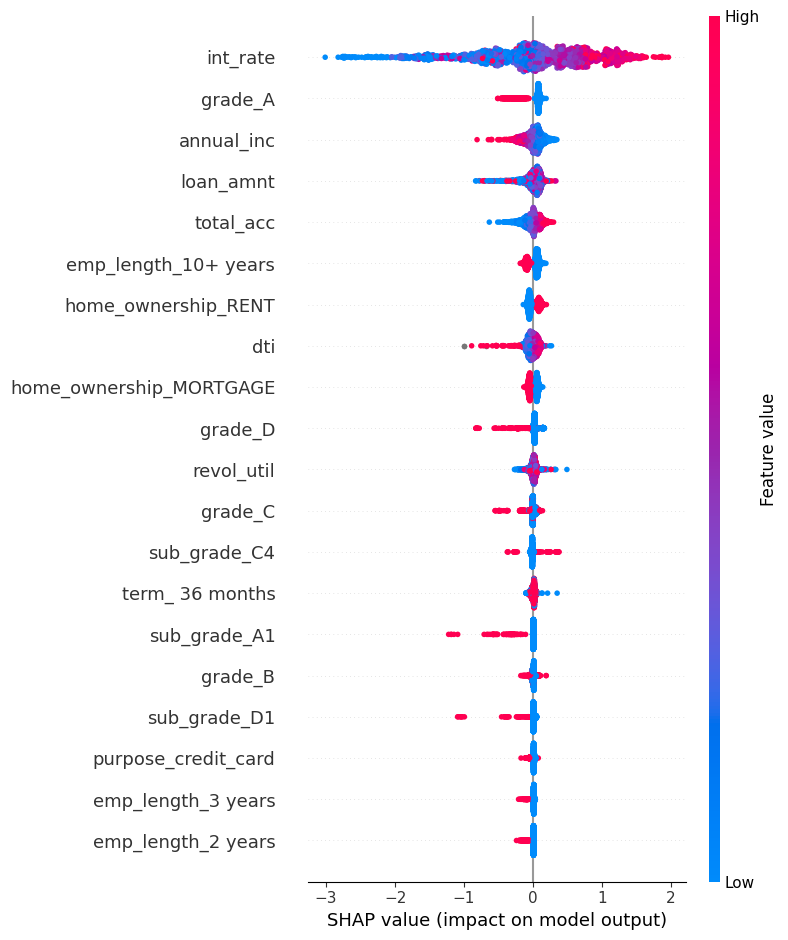

In [7]:
# Convert to float32 for SHAP
X_train_enc = X_train_enc.astype("float32")
X_test_enc  = X_test_enc.astype("float32")

# SHAP explainability
explainer = shap.Explainer(xgb, X_train_enc)
shap_values = explainer(X_test_enc[:2000])  # subset for speed

# Summary plot
shap.summary_plot(shap_values, X_test_enc[:2000], feature_names=X_test_enc.columns)

### 7.2 Local Explainability
Pick individual borrowers and generate SHAP force plots to see which features drove their specific risk prediction.


Borrower 1 (index 1860)


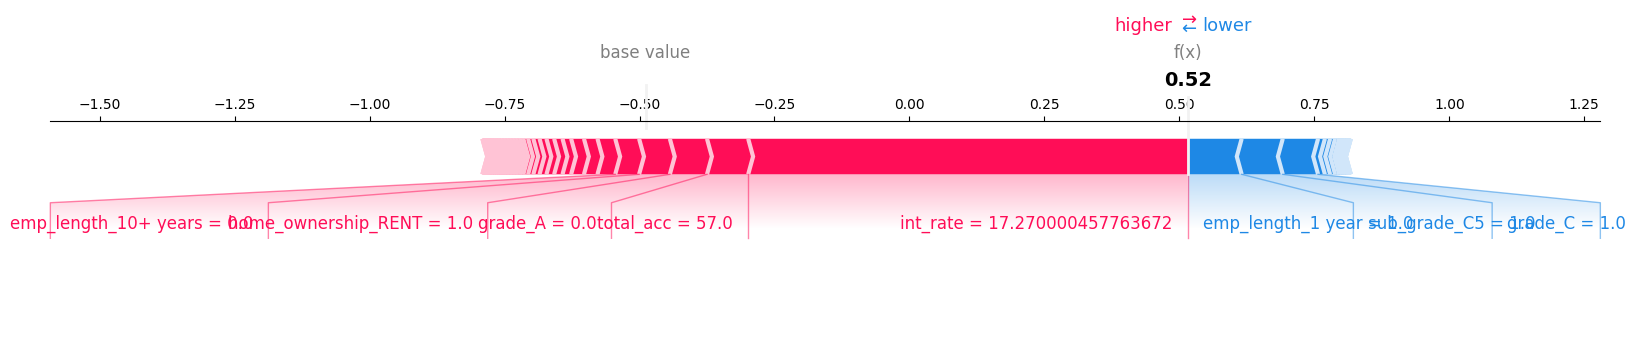


Borrower 2 (index 353)


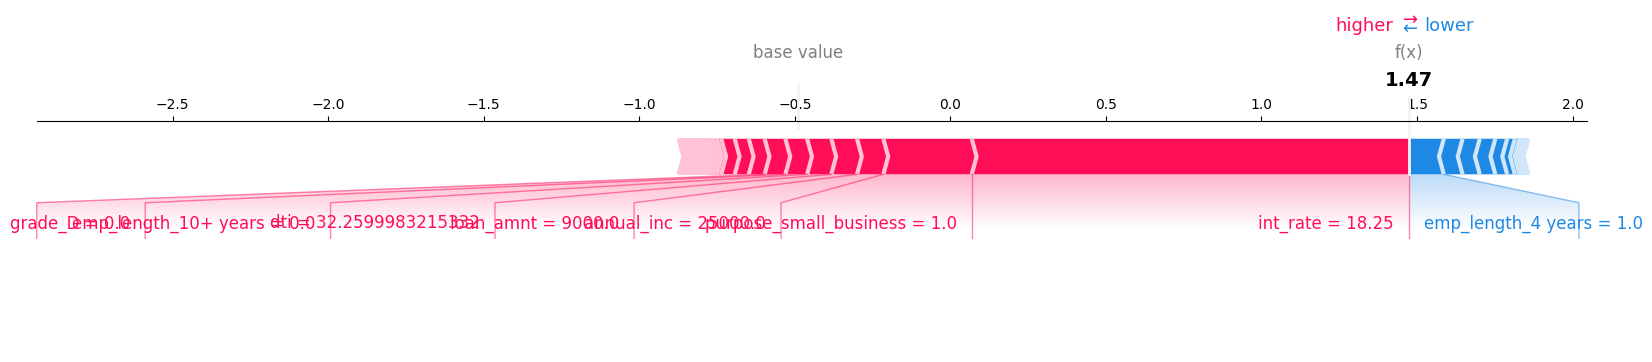


Borrower 3 (index 1333)


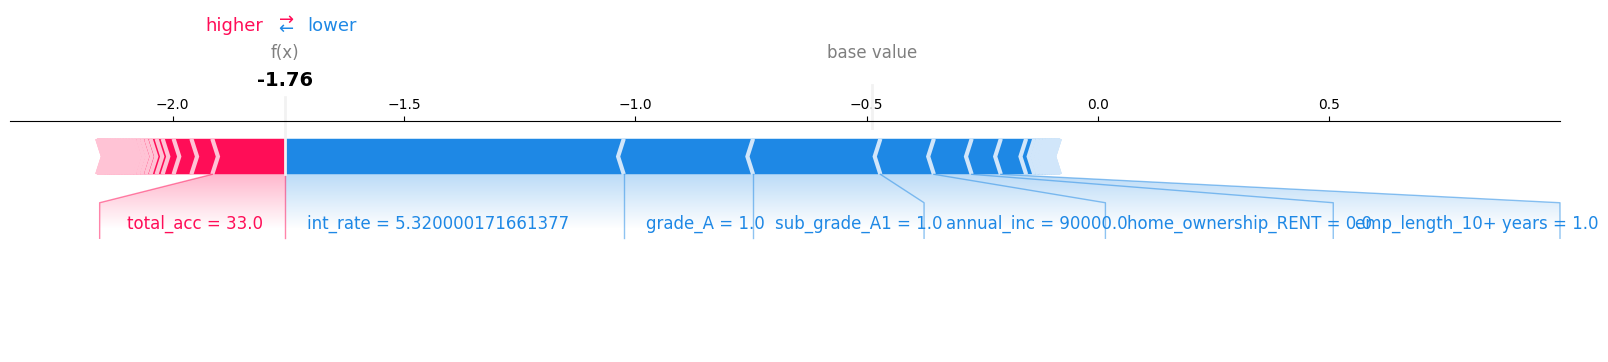


Borrower 4 (index 905)


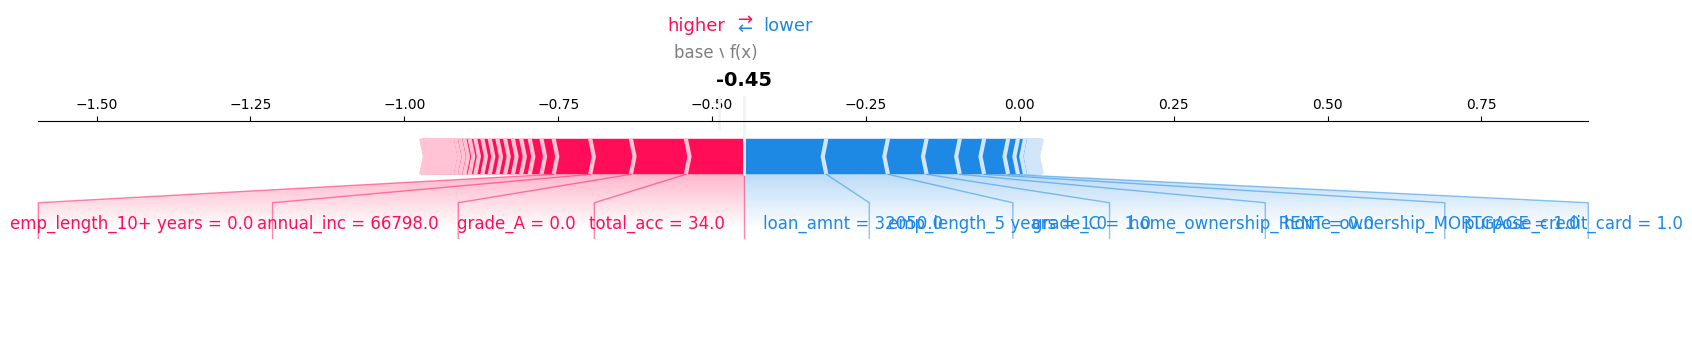


Borrower 5 (index 1289)


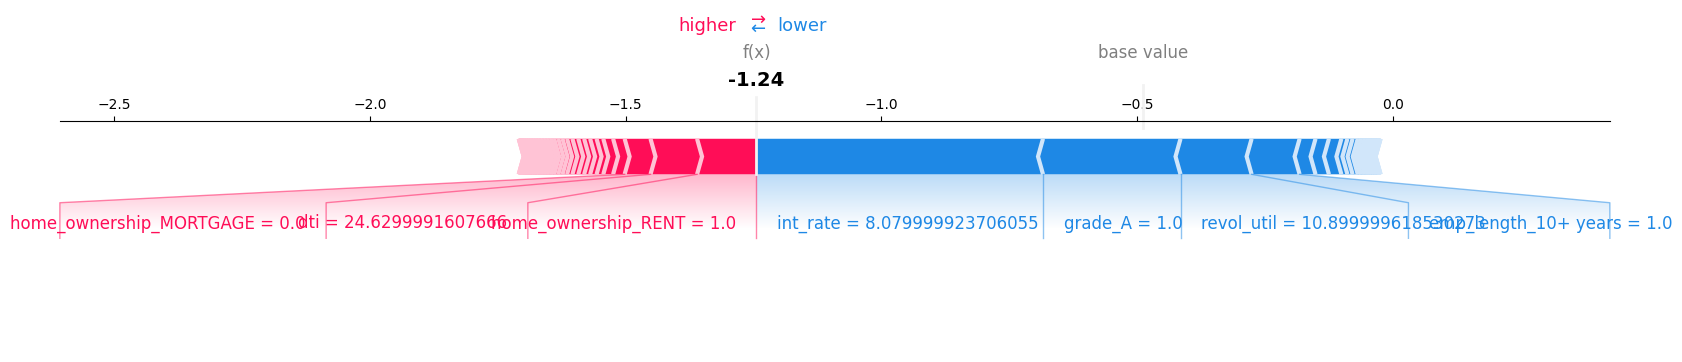

In [8]:
import numpy as np

# Pick 5 random borrowers
np.random.seed(42)
sample_ids = np.random.choice(len(X_test_enc[:2000]), 5, replace=False)

for i, idx in enumerate(sample_ids):
    print(f"\nBorrower {i+1} (index {idx})")
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx].values,
        X_test_enc.iloc[idx, :],
        matplotlib=True
    )
    plt.show()

## Conclusion

- **Logistic Regression** achieved a ROC-AUC of ~0.714.  
- **XGBoost** improved performance to ~0.761, with slightly better recall for default cases when using `scale_pos_weight` to handle class imbalance.  
- **SHAP explainability** highlighted that interest rate, loan grade, loan term, and debt-to-income ratio (DTI) are the most important features influencing credit risk predictions.  

This project demonstrates a complete machine learning workflow:
1. Data preparation and preprocessing  
2. Baseline modeling with Logistic Regression  
3. Advanced modeling with XGBoost  
4. Model evaluation with ROC-AUC and classification metrics  
5. Explainability at both global and local levels using SHAP  

This mirrors real-world credit risk analysis pipelines in the banking sector.  